In [1]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.fundamental import chain_outlier, get_focus_tickers, best_performers
from utils.pricing import load_px_close, get_return_intervals 
from utils.pricing import dummy_col, discret_rets, sample_wgts, px_fwd_ret
from utils.pricing import px_mom_feats, px_mom_co_feats_light, px_fwd_rets, get_ind_index
from utils.pricing import eq_wgt_indices, to_index_form, rename_col

pd.options.display.float_format = '{:,.2f}'.format

import time, os, sys
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

Loading utils/config.json


Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Context data

In [3]:
# context
bench = '^GSPC'
y_col = 'fwdReturn'
companies = excl(config['companies'], [])

context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'ds_name': 'co-technicals-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*3,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 300, #850
    'max_iter': 10, #50
    'l2_reg': 0.01,
}

In [4]:
# get latest pricing file from inferece server
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-ds                                100%   18MB  17.7MB/s   00:00    


In [5]:
# Quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

quotes = load_csvs('quote_consol', [tgt_date])
quotes = quotes.loc[quotes.symbol.isin(companies)]
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile = profile.loc[profile.symbol.isin(companies)]
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-20
Loading file quote/csv/2019-05-20
Loading file summary-categories/assetProfile


In [6]:
# load stored pricing
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
clean_co_px = px_close.dropna(subset=[bench])[companies]

cut_range = get_return_intervals(
    clean_co_px, 
    context['look_ahead'], 
    tresholds=[0.25, 0.75])

print(f'Return intervals {np.round(cut_range, 3)}')

<class 'pandas.core.frame.DataFrame'>
Index: 4673 entries, 2004-05-19 to 2019-05-20
Columns: 1278 entries, 0700.HK to KRW=X
dtypes: float32(1278)
memory usage: 22.8+ MB
px_close.info() None
Return intervals [  -inf -0.176 -0.107  0.14   0.252    inf]


In [7]:
# Training/inference subset
tgt_sectors = [
    'Technology',
    'Healthcare',
    'Industrials',
    'Basic Materials',
    'Consumer Cyclical',
    'Financial Services',
    'Consumer Defensive',
    'Real Estate',
    'Utilities',
    'Communication Services',
    'Energy',
]

subset = list(best_performers(clean_co_px, companies, days=252*7, q=0.75).index)
context['tickers'] = subset

260 companies above 2.968x in the last 7.0 years


### Final

In [8]:
def pre_process_ds(context):
    
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')
    
    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()
    
    # create price momentum features
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    joined_df = pd.concat(super_list, axis=0)
    joined_df = chain_outlier(joined_df, None)
        
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
#     joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    joined_df.dropna(inplace=True)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df

In [10]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']
    
    joined_df = pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols: pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model    
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])    

    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
    probs = np.round(preds,3)
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'    
    
#     # store in S3
#     s3_path = context['s3_path']
#     s3_df = pred_df.reset_index(drop=False)
#     rename_col(s3_df, 'index', 'pred_date')
#     csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

#### Predict

In [11]:
%%time 
# predict for all
pred_df = predict_ds(context)

Sectors: 11, Industries: 84


0it [00:00, ?it/s]/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
13it [00:01, 10.35it/s]

ABMD missing profile, skipping


31it [00:03, 10.85it/s]

JBT missing profile, skipping


81it [00:08, 10.44it/s]

ODFL missing profile, skipping


105it [00:11,  9.85it/s]

LRCX missing profile, skipping


111it [00:11, 10.71it/s]

CBOE missing profile, skipping


156it [00:16,  9.85it/s]

IBKR missing profile, skipping


188it [00:20,  9.47it/s]

ROP missing profile, skipping


260it [00:28,  8.62it/s]


pred_X.shape (191268, 29)
pred_X.shape (191268, 29)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF.h5
CPU times: user 1min 7s, sys: 3.34 s, total: 1min 10s
Wall time: 57.9 s


#### Visualize

In [12]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


neutral   0.67
bull      0.18
long      0.08
bear      0.05
short     0.01
Name: pred_label, dtype: float64

In [13]:
subset[:5]

['TREE', 'NFLX', 'BEAT', 'TAL', 'VIPS']

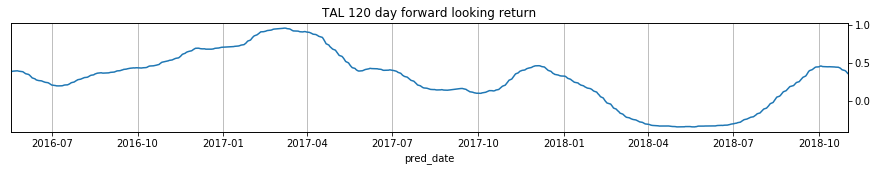

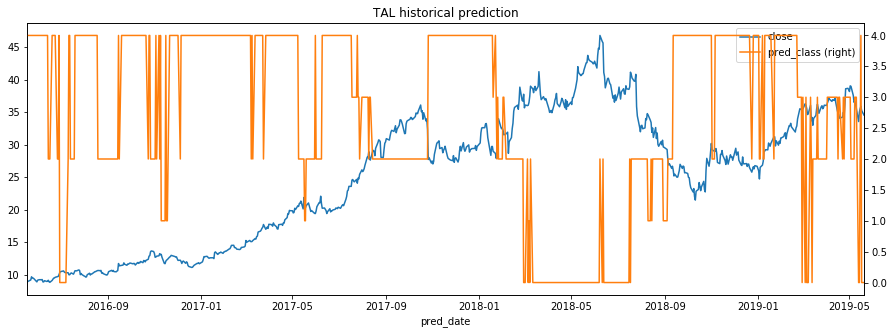

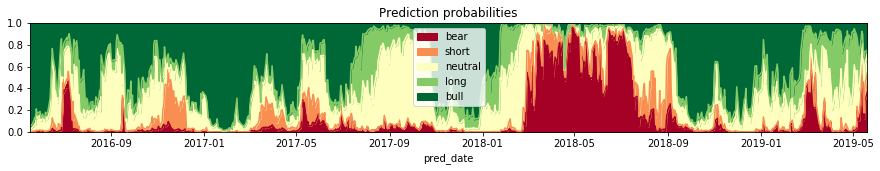

In [14]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_fwd_ret(px_df, look_ahead, int(look_ahead/4))
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + fwd_ret_labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(15, 2), grid=True, secondary_y='pct_chg')

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(15, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[fwd_ret_labels].plot.area(
        title='Prediction probabilities', 
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)

symbol = 'TAL'
plot_symbol_hist_pred(symbol, clean_co_px, context, pred_df)

In [15]:
pred_df.loc[pred_df.symbol.isin([symbol])].head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2016-05-18,TAL,4,bull,0.95,0.00,0.00,0.02,0.02,0.95
2016-05-19,TAL,4,bull,0.94,0.00,0.00,0.03,0.03,0.94
2016-05-20,TAL,4,bull,0.94,0.00,0.00,0.03,0.03,0.94
2016-05-23,TAL,4,bull,0.89,0.00,0.00,0.05,0.05,0.89
2016-05-24,TAL,4,bull,0.87,0.00,0.00,0.07,0.06,0.87


#### AI driven portfolio construction, single period

In [16]:
loss_protection = False
long = True
max_loss = 0.1
holding_period = 60
as_of_date = -holding_period; study_period = -30;
min_confidence = 0.8
max_class_rows = 50
nbr_positions = 30
pred_classes = [3, 4] if long else [0, 1]
period_range = list(range(-holding_period, -pred_df.index.unique().shape[0], -holding_period))

In [17]:
def get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])) \
        & (pred_df.confidence > min_confidence)

    top_pred = pred_df.loc[(pred_df.index == pred_df.index.unique()[as_of_date]) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)\
        .groupby(by='pred_label').head(max_class_rows)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)

In [18]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    return pred_df.index.unique()[study_period + as_of_date:as_of_date]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

Index([2019-01-10, 2019-01-11, 2019-01-14, 2019-01-15, 2019-01-16, 2019-01-17,
       2019-01-18, 2019-01-22, 2019-01-23, 2019-01-24, 2019-01-25, 2019-01-28,
       2019-01-29, 2019-01-30, 2019-01-31, 2019-02-01, 2019-02-04, 2019-02-05,
       2019-02-06, 2019-02-07, 2019-02-08, 2019-02-11, 2019-02-12, 2019-02-13,
       2019-02-14, 2019-02-15, 2019-02-19, 2019-02-20, 2019-02-21, 2019-02-22],
      dtype='object', name='pred_date')

In [19]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, treshold=0.6):
    """ return most frequent predictions of a given class for a study period """
    
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']
    ].reset_index()

    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class'])\
        .agg(['count', 'mean']).reset_index()
    
    return most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * treshold))]\
        .sort_values(by=('confidence', 'count'), ascending=False)
        
most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
top_pos = most_freq_df.head(nbr_positions)
symbols = list(top_pos.symbol)
print(f'{len(symbols)} Symbols: {symbols}')
top_pos

2 Symbols: ['SFTBY', 'WWE']


symbol pred_class confidence     
                          count mean
44  SFTBY          4         29 0.88
48    WWE          4         26 0.51

In [20]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    pos = truth_df[truth_df == True]
    if len(pos): df.loc[pos.index[0]:] = df.loc[pos.index[0]]
    return df

idx = clean_co_px.index.get_loc(study_dates[-1])
prices = clean_co_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')

Showing returns from Index([2019-02-22, 2019-05-17], dtype='object')
Portfolio shape: (60, 3)


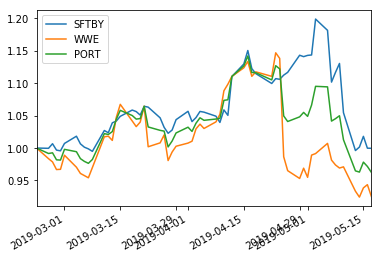

In [21]:
port_index.plot()

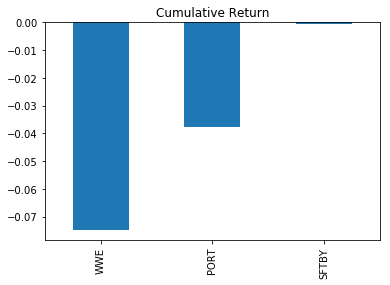

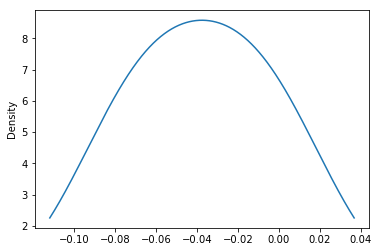

In [22]:
(port_index.iloc[-1] - 1).sort_values().plot.bar(title='Cumulative Return'); plt.show()
(port_index.iloc[-1] - 1).plot.kde();

In [23]:
# cumulative returns for a given portfolio
port_index.iloc[-1].describe()

count   3.00
mean    0.96
std     0.04
min     0.93
25%     0.94
50%     0.96
75%     0.98
max     1.00
Name: 2019-05-17 00:00:00, dtype: float64

In [24]:
port_index.tail()

,SFTBY,WWE,PORT
2019-05-13,1.00,0.93,0.96
2019-05-14,1.00,0.92,0.96
2019-05-15,1.02,0.94,0.98
2019-05-16,1.00,0.94,0.97
2019-05-17,1.00,0.93,0.96


#### Backtesting experiment, historical periods

In [25]:
# What are the best portfolios and how do they perform?
super_list = []; symbol_list = []
for as_of_date in period_range:

    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
    top_pos = most_freq_df.head(nbr_positions)
    symbols = list(top_pos.symbol)
    
    if len(symbols) > 3:
        idx = clean_co_px.index.get_loc(study_dates[-1])
        prices = clean_co_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        exp = port_index.iloc[-1].describe()
        exp['offset_start'] = as_of_date
        exp['as_of_date'] = str(study_dates[-1])
        exp['study_period'] = study_period
        exp['end_date'] = str(port_index.index[-1])
        symbol_list.append(symbols)
        super_list.append(exp)
        
hist_ports = pd.concat(super_list, axis=1).T

Summary for 12 experiment LONG periods
40 unique symbols


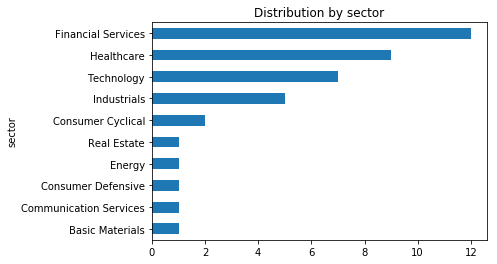

sector                  industry                                
Financial Services      Capital Markets                             5
                        Banks - Regional - US                       4
Healthcare              Diagnostics & Research                      2
Technology              Internet Content & Information              2
Industrials             Airlines                                    2
Healthcare              Medical Devices                             2
Technology              Semiconductors                              1
Communication Services  Telecom Services                            1
Consumer Cyclical       Leisure                                     1
                        Lodging                                     1
Consumer Defensive      Farm Products                               1
Energy                  Oil & Gas Refining & Marketing              1
Financial Services      Asset Management                            1
                        B

In [26]:
# Descriptive stats
print(f'Summary for {len(period_range)} experiment {"LONG" if long else "SHORT"} periods')
unique_symbols = set(np.concatenate(symbol_list))
print(f'{len(unique_symbols)} unique symbols')

by_sect = profile.loc[unique_symbols].groupby(by=['sector']).count().iloc[:,0]\
      .sort_values()
by_sect.plot.barh(title='Distribution by sector');
plt.show()

by_ind = profile.loc[unique_symbols].groupby(by=['sector', 'industry']).count().iloc[:,0]\
      .sort_values(ascending=False)
by_ind.head(20)

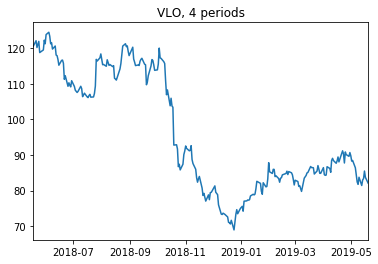

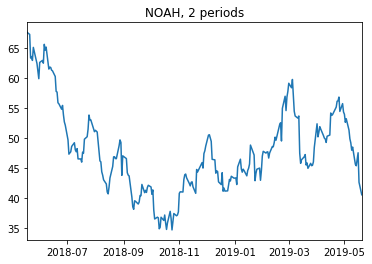

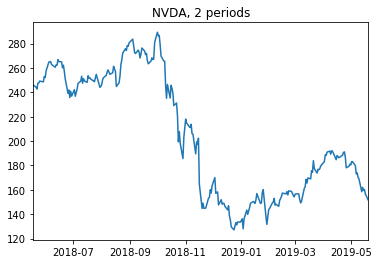

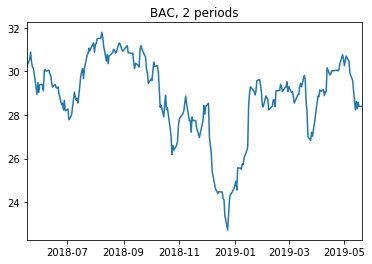

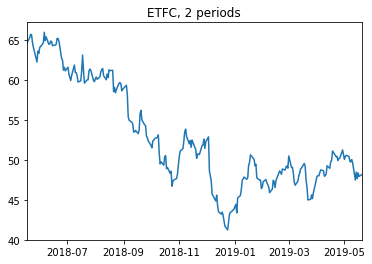

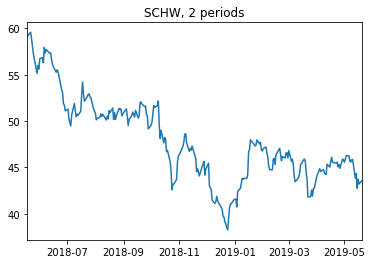

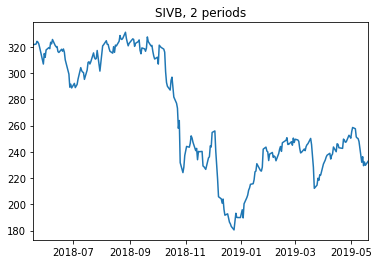

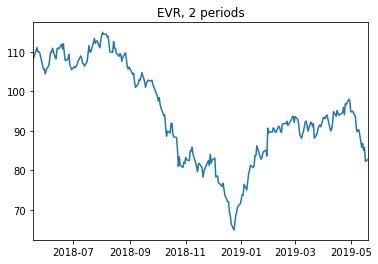

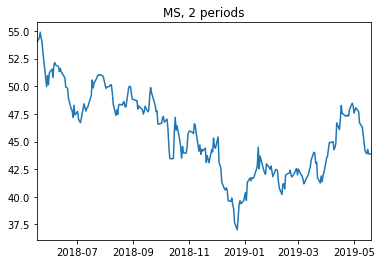

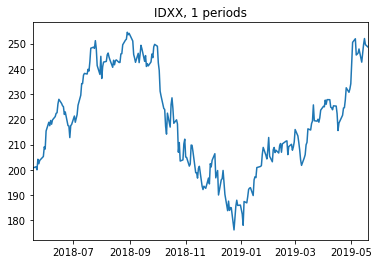

In [27]:
# Most common recommendations
from collections import Counter
pos_freq = Counter(np.concatenate(symbol_list)).most_common()
for t in pos_freq[:10]: clean_co_px[t[0]].tail(252).plot(title=f'{t[0]}, {t[1]} periods'); plt.show()

In [28]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

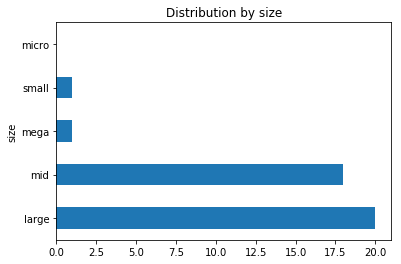

In [29]:
size_df = quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

Long CAGR: 1.11


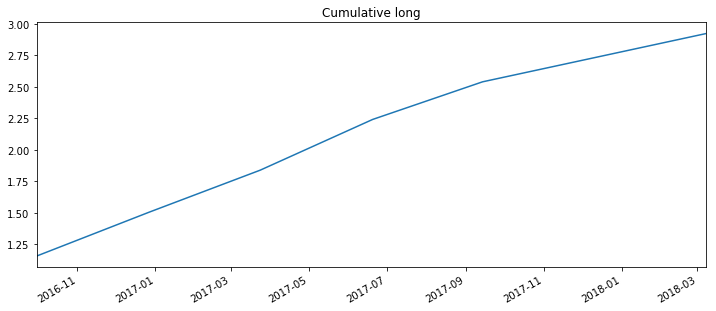

In [30]:
hist_ports.sort_index(inplace=True)
years = (hist_ports.index[-1] - hist_ports.index[0]).days / 365
if long:
    mean_ret = pd.DataFrame()
    mean_ret['long'] = hist_ports['mean'].sort_index()
    mean_ret['long'].cumprod().plot(title='Cumulative long', figsize=(12,5));
    print(f'Long CAGR: {round((mean_ret["long"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
else:
    mean_ret['short'] = hist_ports['mean'].sort_index()
    mean_ret['short'].cumprod().plot(title='Cumulative short', figsize=(12,5));
    print(f'Short CAGR: {round((mean_ret["short"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
if 'long' in mean_ret.columns and 'short' in mean_ret.columns:
    mean_ret['ls'] = (mean_ret['long'] - mean_ret['short'] + 1)
    mean_ret.cumprod().plot(title='Long/Short', figsize=(12,5))          
    print(f'L/S CAGR: {(mean_ret["ls"].cumprod().iloc[-1] ** (1/years) - 1)}')

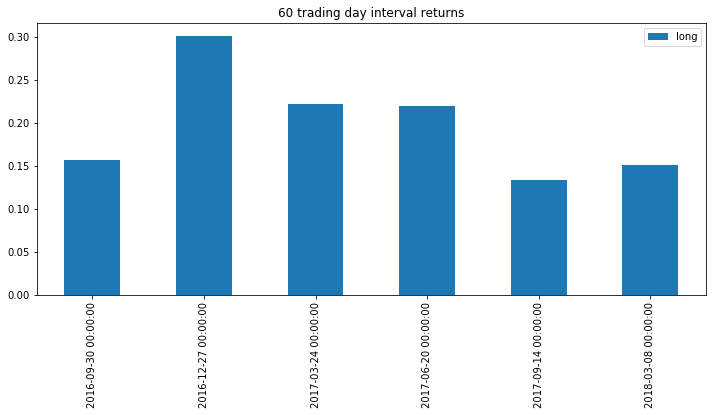

In [31]:
(mean_ret-1).plot(
    title=f'{holding_period} trading day interval returns', 
    kind='bar', figsize=(12,5))

In [32]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long'] - 1).mul(l_w) - 
        (mean_ret['short'] - 1).mul(1 - l_w) + 1)
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [33]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
        monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(((scenarios['mean'] - 1) / scenarios['std']))]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
    print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
    monthly_ret.cumprod().plot();

In [34]:
hist_ports.infer_objects()['mean'].describe()

count   6.00
mean    1.20
std     0.06
min     1.13
25%     1.15
50%     1.19
75%     1.22
max     1.30
Name: mean, dtype: float64

In [35]:
hist_ports.infer_objects().describe()

,count,mean,std,min,25%,50%,75%,max,offset_start,study_period
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,9.50,1.20,0.10,1.05,1.14,1.18,1.25,1.36,-560.00,-30.00
std,3.73,0.06,0.05,0.10,0.05,0.07,0.09,0.14,129.61,0.00
min,5.00,1.13,0.05,0.85,1.08,1.11,1.16,1.23,-720.00,-30.00
25%,6.75,1.15,0.06,1.06,1.12,1.15,1.19,1.24,-645.00,-30.00
50%,9.50,1.19,0.08,1.08,1.13,1.17,1.23,1.31,-570.00,-30.00
75%,11.50,1.22,0.12,1.10,1.14,1.19,1.30,1.43,-495.00,-30.00
max,15.00,1.30,0.18,1.12,1.24,1.31,1.39,1.59,-360.00,-30.00


In [36]:
hist_ports.sort_values(by='offset_start')

,count,mean,std,min,25%,50%,75%,max,offset_start,as_of_date,study_period,end_date
2016-09-30,12.00,1.16,0.05,1.09,1.12,1.15,1.20,1.23,-720.00,2016-07-08,-30,2016-09-30 00:00:00
2016-12-27,15.00,1.30,0.18,0.85,1.24,1.31,1.39,1.59,-660.00,2016-10-03,-30,2016-12-27 00:00:00
2017-03-24,10.00,1.22,0.09,1.12,1.14,1.20,1.31,1.37,-600.00,2016-12-28,-30,2017-03-24 00:00:00
2017-06-20,6.00,1.22,0.13,1.11,1.12,1.18,1.26,1.45,-540.00,2017-03-27,-30,2017-06-20 00:00:00
2017-09-14,9.00,1.13,0.07,1.06,1.08,1.11,1.19,1.25,-480.00,2017-06-21,-30,2017-09-14 00:00:00
2018-03-08,5.00,1.15,0.06,1.07,1.14,1.15,1.16,1.24,-360.00,2017-12-11,-30,2018-03-08 00:00:00
